In [1]:
from google.colab import drive
drive.mount('gdrive')
#Run this

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [2]:
import zipfile
import os

# Define the path to the zip file and extraction destination
zip_file_path = '/content/gdrive/MyDrive/FER2013_happy_sad.zip'
extraction_path = '/content/FER2013_happy_sad/'  # The folder where you want to extract the contents

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f'Files extracted to: {extraction_path}')

#Run this

Files extracted to: /content/FER2013_happy_sad/


In [3]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Paths to the dataset
dataset_path = '/content/FER2013_happy_sad'  # Change to your mounted path

# Emotions available in the dataset
emotions = ['happy', 'sad']

#Run this

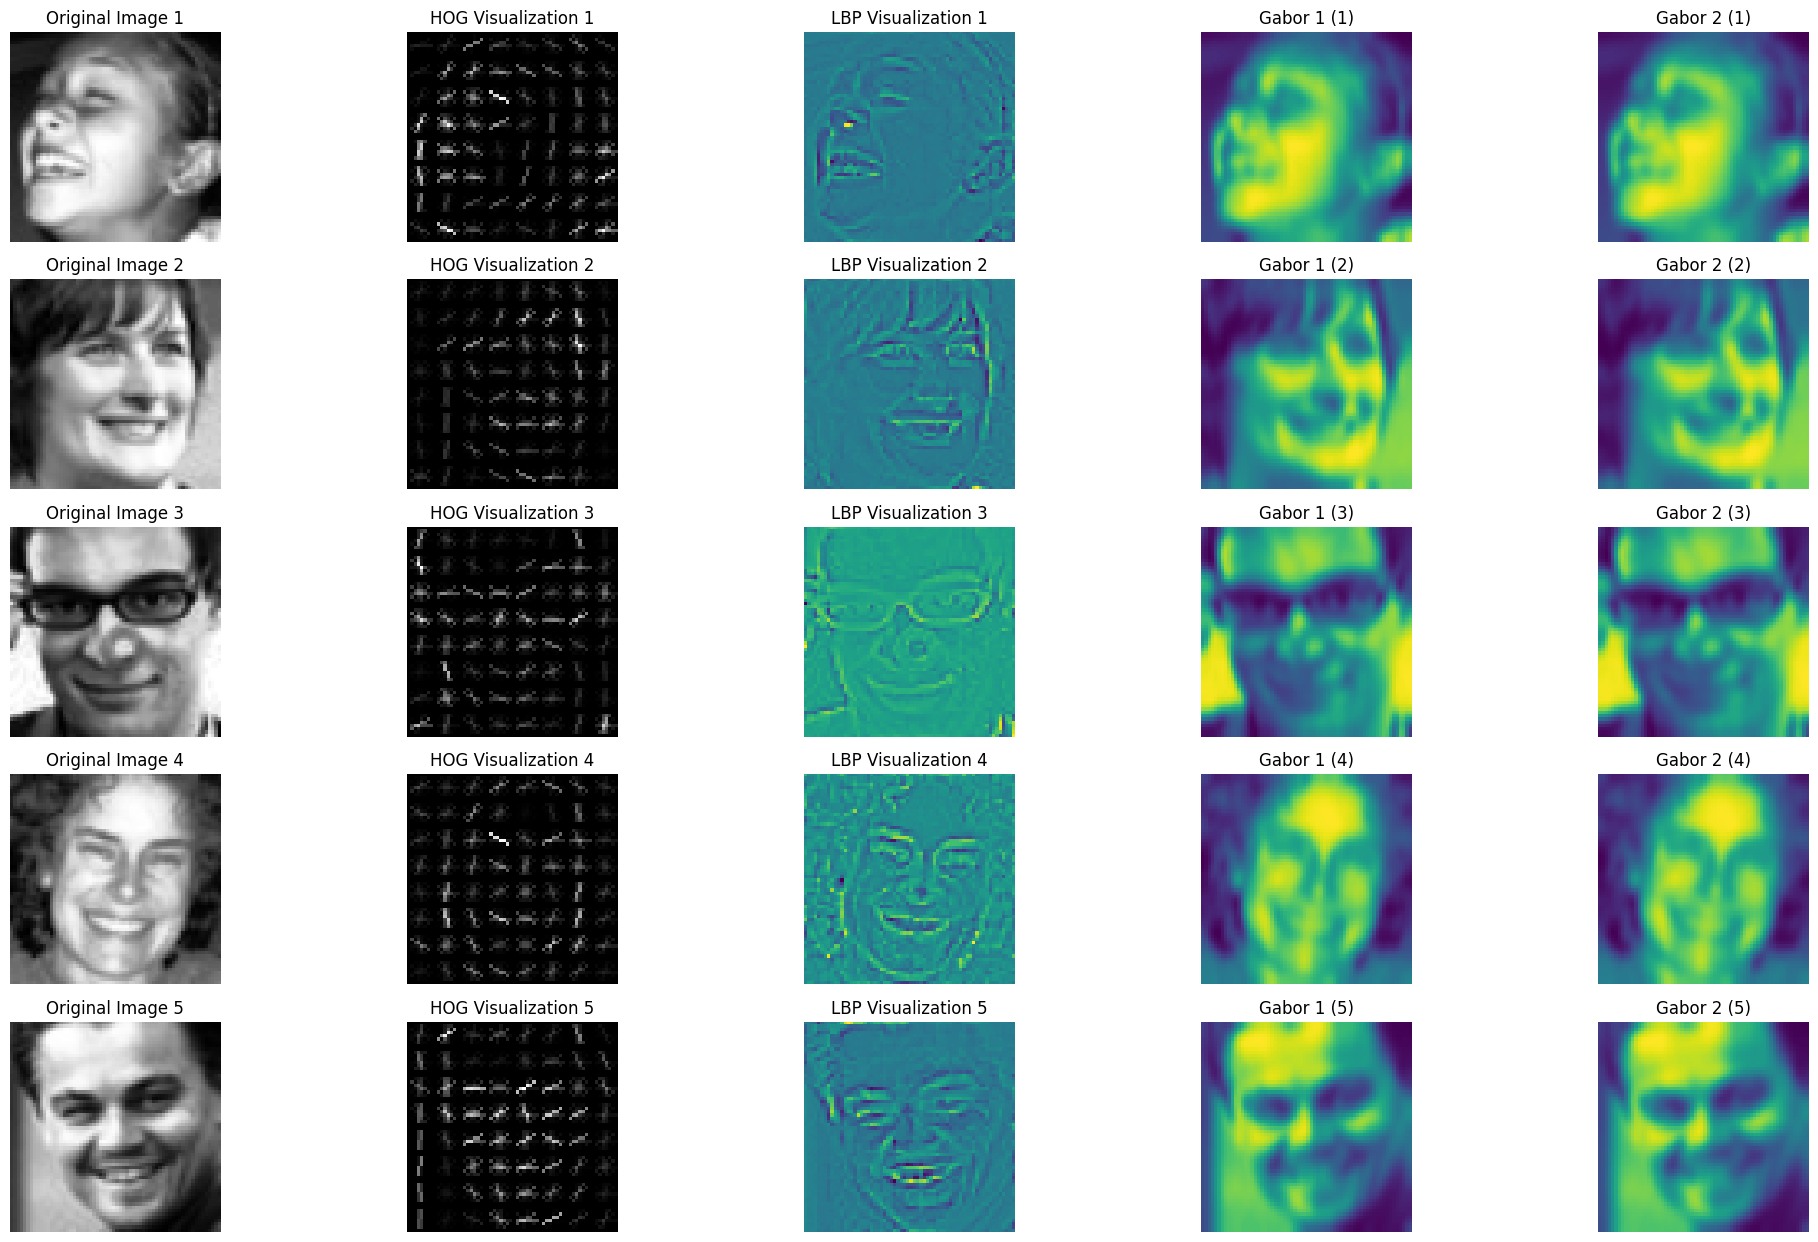

In [4]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

# Preprocessing function
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    resized_img = cv2.resize(gray, (64, 64))
    return resized_img

# Function to apply Gabor filters
def apply_gabor_filters(image):
    gabor_responses = []
    gabor_visualizations = []

    # Define Gabor filter parameters
    for theta in np.arange(0, np.pi, np.pi / 4):  # 4 orientations
        for sigma in (1, 3):  # 2 scales
            for lamda in (8, 16):  # 2 wavelengths
                kernel = cv2.getGaborKernel((9, 9), sigma, theta, lamda, 0.5, 0, ktype=cv2.CV_64F)
                filtered_image = cv2.filter2D(image, cv2.CV_64F, kernel)
                gabor_responses.append(filtered_image.var())  # Capture variance as feature
                gabor_visualizations.append(filtered_image)  # Keep for visualization

    return np.array(gabor_responses), gabor_visualizations

# Extract HOG, LBP, and Gabor features combined
def extract_features(images):
    features = []
    hog_visualizations = []
    lbp_visualizations = []
    gabor_visualizations = []

    for img in images:
        img_preprocessed = preprocess_image(img)

        # HOG feature extraction
        hog_features, hog_image = hog(img_preprocessed, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

        # LBP feature extraction (example using Laplacian variance for simplicity)
        lbp = cv2.Laplacian(img_preprocessed, cv2.CV_64F).var()

        # Gabor filter feature extraction
        gabor_features, gabor_imgs = apply_gabor_filters(img_preprocessed)

        # Combine features
        combined_features = np.hstack((hog_features, [lbp], gabor_features))
        features.append(combined_features)

        # Collect visualizations
        hog_visualizations.append(hog_image)
        lbp_visualizations.append(cv2.Laplacian(img_preprocessed, cv2.CV_64F))
        gabor_visualizations.append(gabor_imgs)  # Append all Gabor visualizations for each image

    return np.array(features), hog_visualizations, lbp_visualizations, gabor_visualizations

# Function to load and preprocess all images in the dataset
def load_images_from_directory(directory):
    images = []
    labels = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)

                    # Extract label from the folder structure
                    label = os.path.basename(os.path.dirname(img_path))
                    labels.append(label)

    return np.array(images), np.array(labels)

# Load and preprocess data
train_path = '/content/FER2013_happy_sad/train'
test_path = '/content/FER2013_happy_sad/test'

X_train_images, y_train = load_images_from_directory(train_path)
X_test_images, y_test = load_images_from_directory(test_path)

X = np.concatenate((X_train_images, X_test_images), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Extract features and visualizations
X_features, hog_visualizations, lbp_visualizations, gabor_visualizations = extract_features(X)

# Display a few visualizations
plt.figure(figsize=(20, 15))
for i in range(5):  # Display visualizations for first 5 images
    img_preprocessed = preprocess_image(X[i])

    # Display original image
    plt.subplot(6, 5, i * 5 + 1)
    plt.imshow(img_preprocessed, cmap='gray')
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Display HOG visualization
    plt.subplot(6, 5, i * 5 + 2)
    plt.imshow(hog_visualizations[i], cmap='gray')
    plt.title(f"HOG Visualization {i+1}")
    plt.axis('off')

    # Display LBP visualization
    plt.subplot(6, 5, i * 5 + 3)
    plt.imshow(lbp_visualizations[i], cmap='viridis')
    plt.title(f"LBP Visualization {i+1}")
    plt.axis('off')

    # Display 2 Gabor visualizations for each image
    plt.subplot(6, 5, i * 5 + 4)
    plt.imshow(gabor_visualizations[i][0], cmap='viridis')
    plt.title(f"Gabor 1 ({i+1})")
    plt.axis('off')

    plt.subplot(6, 5, i * 5 + 5)
    plt.imshow(gabor_visualizations[i][1], cmap='viridis')
    plt.title(f"Gabor 2 ({i+1})")
    plt.axis('off')

plt.tight_layout()
plt.show()


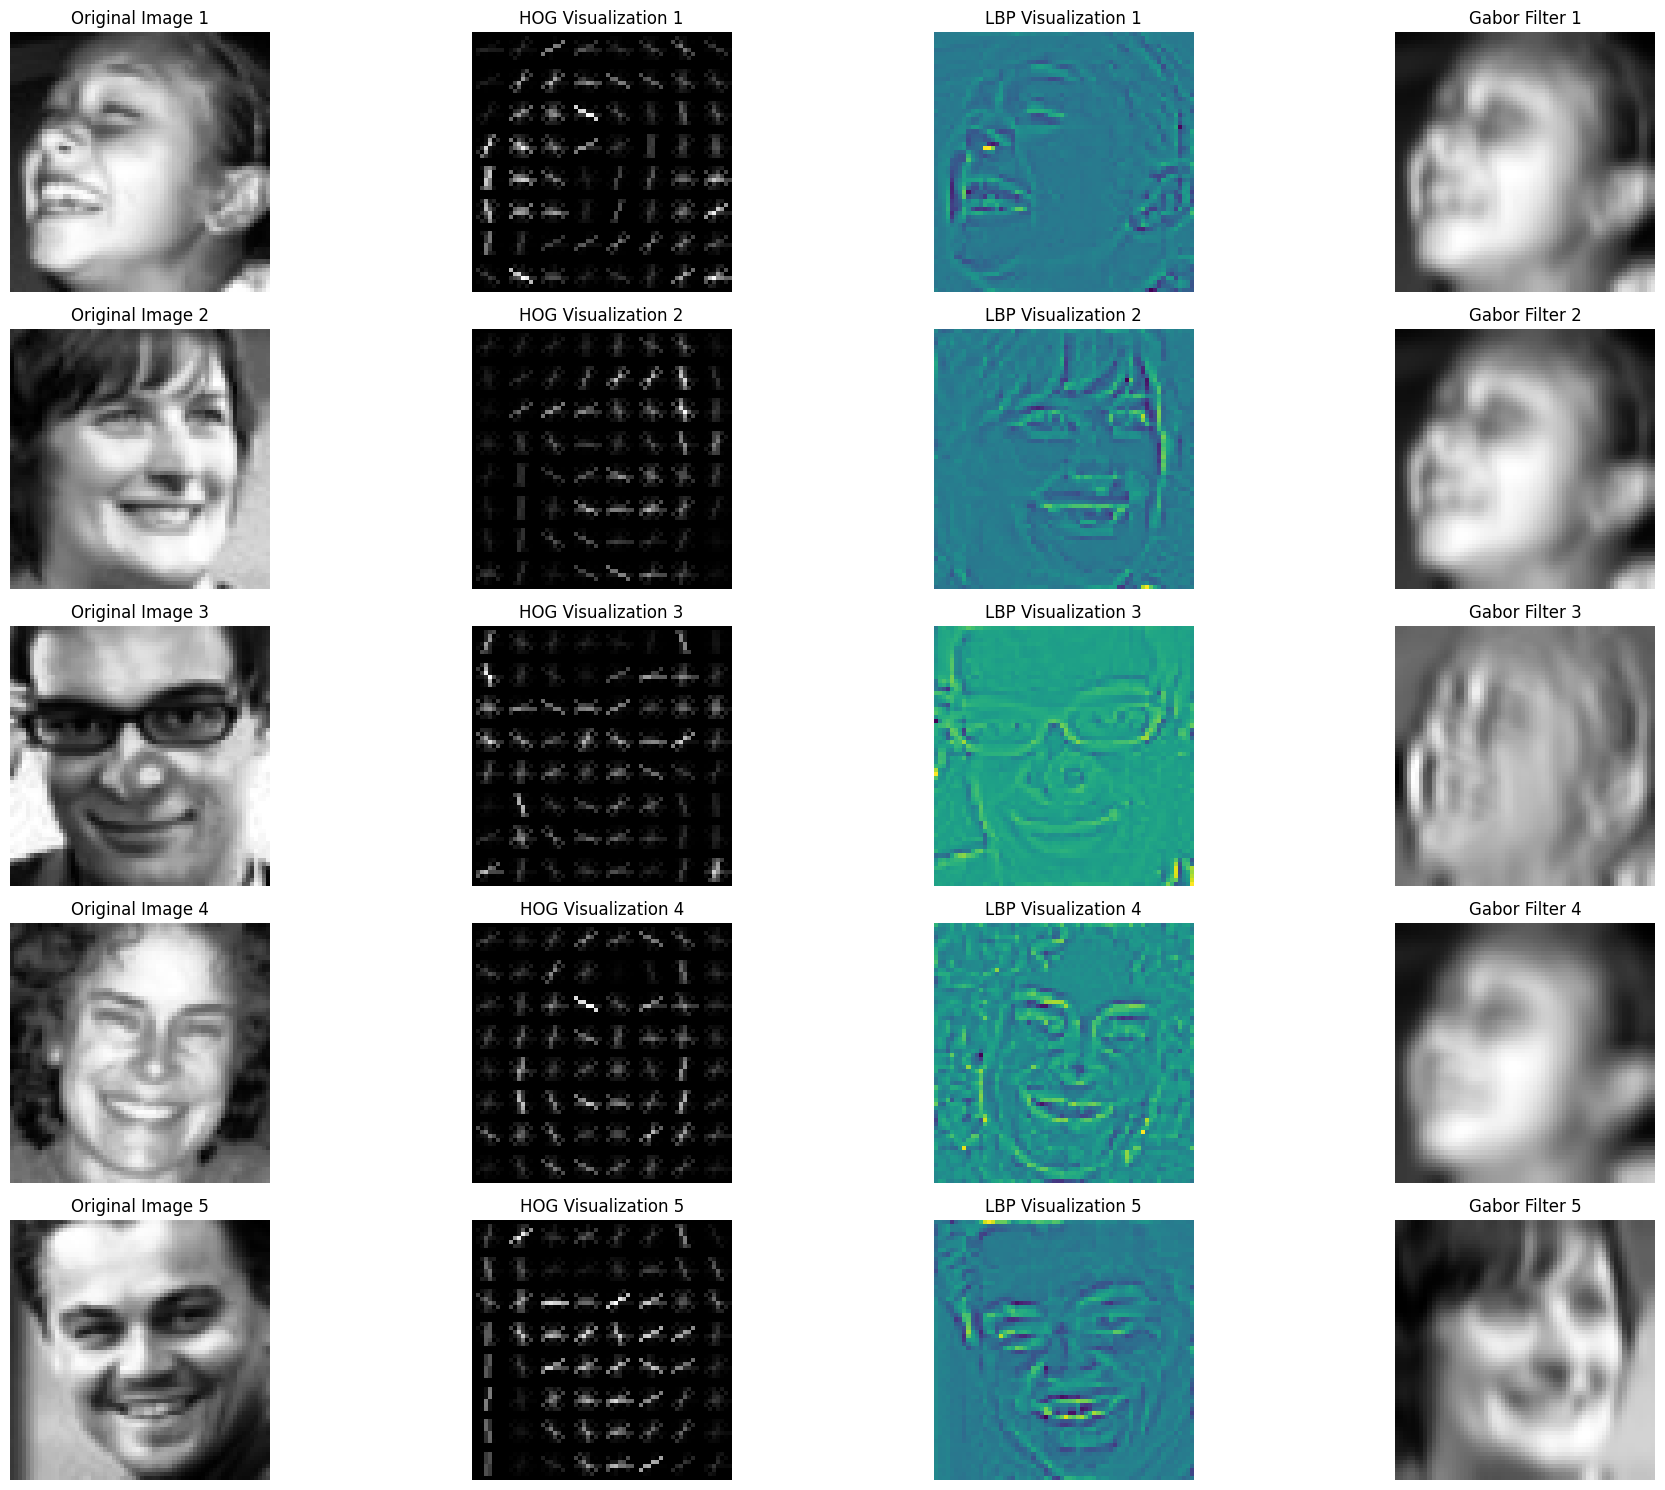

SVM with RBF Kernel Accuracy: 83.51%
Classification Report:
              precision    recall  f1-score   support

       happy       0.85      0.88      0.86      1798
         sad       0.81      0.77      0.79      1216

    accuracy                           0.84      3014
   macro avg       0.83      0.83      0.83      3014
weighted avg       0.83      0.84      0.83      3014



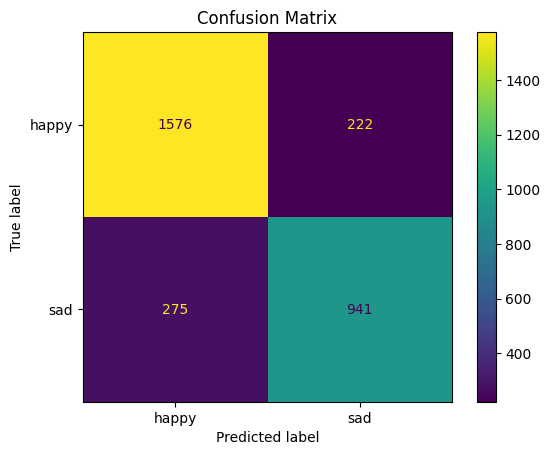

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

# Preprocessing function
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    resized_img = cv2.resize(gray, (64, 64))
    return resized_img

# Function to apply Gabor filters
def apply_gabor_filters(image):
    gabor_responses = []
    gabor_visualizations = []

    # Define Gabor filter parameters
    for theta in np.arange(0, np.pi, np.pi / 4):  # 4 orientations
        for sigma in (1, 3):  # 2 scales
            for lamda in (8, 16):  # 2 wavelengths
                kernel = cv2.getGaborKernel((9, 9), sigma, theta, lamda, 0.5, 0, ktype=cv2.CV_64F)
                filtered_image = cv2.filter2D(image, cv2.CV_64F, kernel)
                gabor_responses.append(filtered_image.var())  # Capture variance as feature
                gabor_visualizations.append(filtered_image)  # Keep for visualization

    return np.array(gabor_responses), gabor_visualizations

# Extract HOG, LBP, and Gabor features combined
def extract_features(images):
    features = []
    hog_visualizations = []
    lbp_visualizations = []
    gabor_visualizations = []

    for img in images:
        img_preprocessed = preprocess_image(img)

        # HOG feature extraction
        hog_features, hog_image = hog(img_preprocessed, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

        # LBP feature extraction (example using Laplacian variance for simplicity)
        lbp = cv2.Laplacian(img_preprocessed, cv2.CV_64F).var()

        # Gabor filter feature extraction
        gabor_features, gabor_imgs = apply_gabor_filters(img_preprocessed)

        # Combine features
        combined_features = np.hstack((hog_features, [lbp], gabor_features))
        features.append(combined_features)

        # Collect visualizations
        hog_visualizations.append(hog_image)
        lbp_visualizations.append(cv2.Laplacian(img_preprocessed, cv2.CV_64F))
        gabor_visualizations.extend(gabor_imgs[:4])  # Select only 4 Gabor visualizations for simplicity

    return np.array(features), hog_visualizations, lbp_visualizations, gabor_visualizations

# Function to load and preprocess all images in the dataset
def load_images_from_directory(directory):
    images = []
    labels = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)

                    # Extract label from the folder structure
                    label = os.path.basename(os.path.dirname(img_path))
                    labels.append(label)

    return np.array(images), np.array(labels)

# Load and preprocess data
train_path = '/content/FER2013_happy_sad/train'
test_path = '/content/FER2013_happy_sad/test'

X_train_images, y_train = load_images_from_directory(train_path)
X_test_images, y_test = load_images_from_directory(test_path)

X = np.concatenate((X_train_images, X_test_images), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Extract features and visualizations
X_features, hog_visualizations, lbp_visualizations, gabor_visualizations = extract_features(X)

# Display a few visualizations
plt.figure(figsize=(20, 15))
for i in range(5):  # Display visualizations for first 5 images
    img_preprocessed = preprocess_image(X[i])

    # Display original image
    plt.subplot(5, 4, i * 4 + 1)
    plt.imshow(img_preprocessed, cmap='gray')
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Display HOG visualization
    plt.subplot(5, 4, i * 4 + 2)
    plt.imshow(hog_visualizations[i], cmap='gray')
    plt.title(f"HOG Visualization {i+1}")
    plt.axis('off')

    # Display LBP visualization
    plt.subplot(5, 4, i * 4 + 3)
    plt.imshow(lbp_visualizations[i], cmap='viridis')
    plt.title(f"LBP Visualization {i+1}")
    plt.axis('off')

    # Display a Gabor visualization
    plt.subplot(5, 4, i * 4 + 4)
    plt.imshow(gabor_visualizations[i], cmap='gray')
    plt.title(f"Gabor Filter {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM with RBF kernel
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM with RBF Kernel Accuracy: {accuracy * 100:.2f}%")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=svm.classes_)
disp.plot(cmap='viridis')

plt.title("Confusion Matrix")
plt.show()


SVM with RBF Kernel Accuracy C=10: 84.41%
Classification Report:
              precision    recall  f1-score   support

       happy       0.86      0.88      0.87      1798
         sad       0.82      0.79      0.80      1216

    accuracy                           0.84      3014
   macro avg       0.84      0.84      0.84      3014
weighted avg       0.84      0.84      0.84      3014



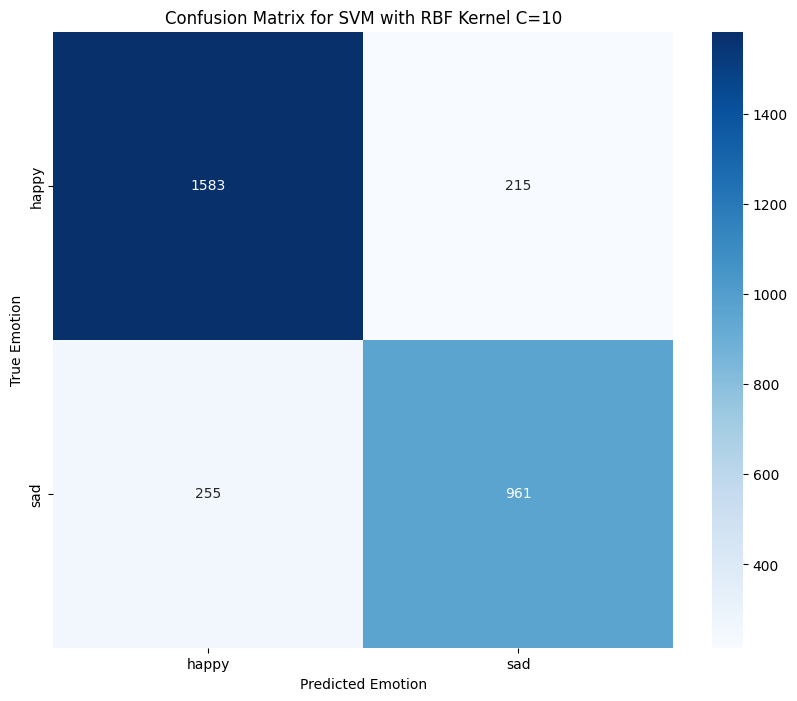

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train an SVM classifier with C=10
svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM with RBF Kernel Accuracy C=10: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix for SVM with RBF Kernel C=10")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.show()

Training the Random Forest Classifier...
Classification Report:
              precision    recall  f1-score   support

       happy       0.77      0.88      0.82      1798
         sad       0.77      0.61      0.68      1216

    accuracy                           0.77      3014
   macro avg       0.77      0.75      0.75      3014
weighted avg       0.77      0.77      0.77      3014

Accuracy: 77.14%


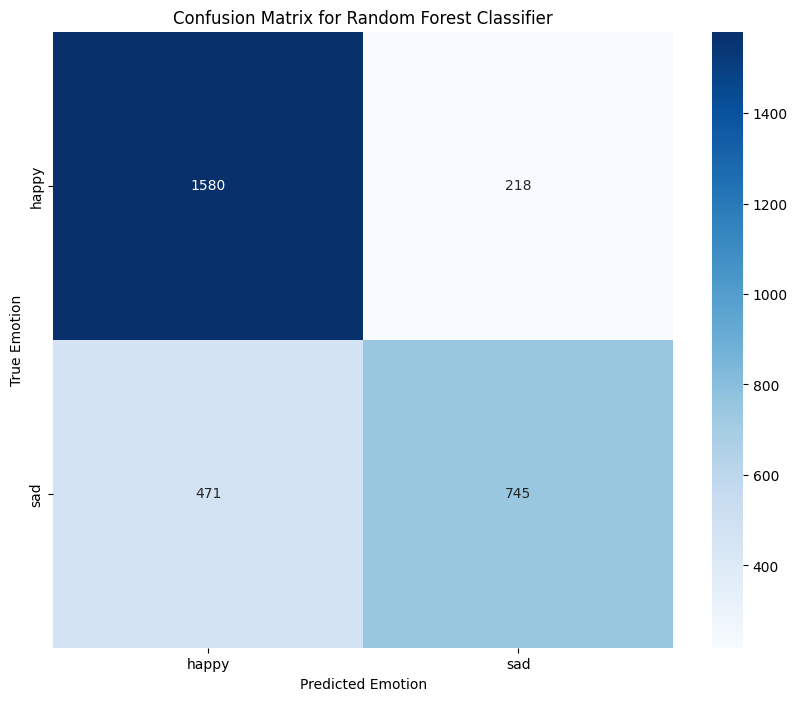

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest Classifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the Random Forest Classifier
print("Training the Random Forest Classifier...")
rf.fit(X_train, y_train)

# Predict the test set results
y_pred = rf.predict(X_test)

# Print the classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.show()


KNN Accuracy: 76.91%
KNN Classification Report:
              precision    recall  f1-score   support

       happy       0.75      0.93      0.83      1798
         sad       0.84      0.53      0.65      1216

    accuracy                           0.77      3014
   macro avg       0.79      0.73      0.74      3014
weighted avg       0.78      0.77      0.76      3014



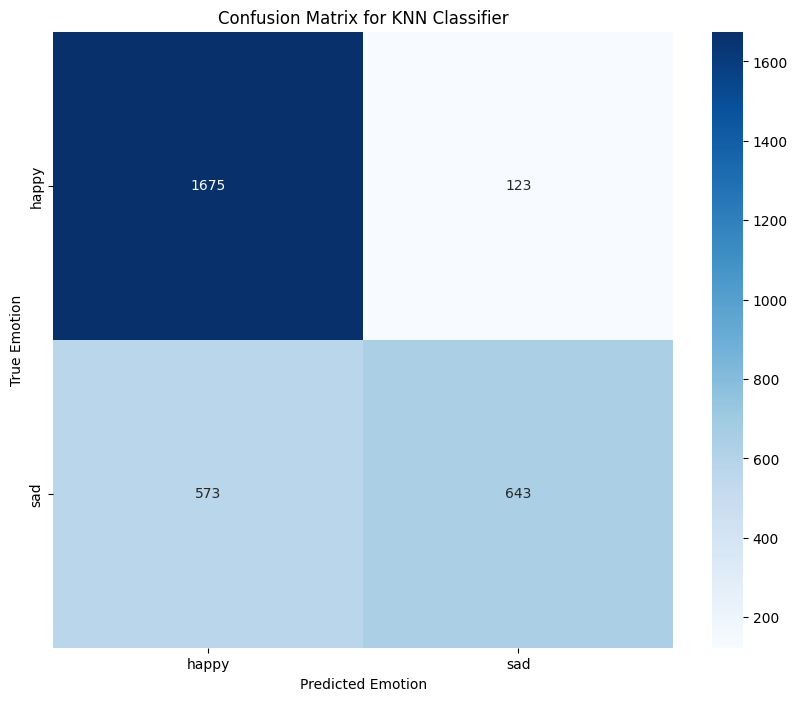

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Train a K-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")
print("KNN Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix for KNN Classifier")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.show()
